## Software empleado

In [1]:
# Bibliotecas
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple, Optional, Union

In [2]:
# %load_ext autoreload
# %autoreload 2
# import visual_utils

In [3]:
sys.path.append(os.path.abspath('notebooks/'))

# Código propio
from visual_utils import * 


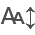

In [4]:
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

# PROBLEMA 1
# ESTIMACIÓN DE EDAD

## Carga de los resultados y obtención de métricas

In [5]:
# Carga de datos
df_AE_raw = pd.read_csv('results/AE_maxillofacial_test_results.csv')

display(df_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [6]:
# Nueva columna: error absoluto
df_AE_raw['absolute_error'] = (df_AE_raw['true_value'] - df_AE_raw['pred_point_value']).abs()

# Nueva columna: error cuadrático
df_AE_raw['squared_error'] = (df_AE_raw['true_value'] - df_AE_raw['pred_point_value']).pow(2)

# Nueva columna: tamaño del intervalo medio
df_AE_raw['pred_interval_width'] = df_AE_raw['pred_upper_bound'] - df_AE_raw['pred_lower_bound']

# Nueva columna: cobertura (true/false)
df_AE_raw['is_covered'] = (df_AE_raw['true_value'] >= df_AE_raw['pred_lower_bound']) & \
                          (df_AE_raw['true_value'] <= df_AE_raw['pred_upper_bound'])

# Nueva columna: interval score  
alpha = 1 - df_AE_raw['confidence']
df_AE_raw['interval_score'] = (
    (df_AE_raw['pred_upper_bound'] - df_AE_raw['pred_lower_bound']) 
    + (2 / alpha) * (df_AE_raw['pred_lower_bound'] - df_AE_raw['true_value']).clip(lower=0) 
    + (2 / alpha) * (df_AE_raw['true_value'] - df_AE_raw['pred_upper_bound']).clip(lower=0)
)

display(df_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [7]:
# Agrupar y calcular métricas
df_AE_by_run = (
    df_AE_raw
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .agg(
        mean_absolute_error=('absolute_error', 'mean'),
        mean_squared_error=('squared_error', 'mean'),
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean'),
        mean_interval_score=('interval_score', 'mean')
    )
    .reset_index()
)

display(df_AE_by_run)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Análisis de la varianza en métricas para predicciones puntuales 

In [42]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Asumiendo que ya tienes df_AE_by_run

# --- Función para formatear tabla ANOVA ---
def format_anova_table(anova_table):
    anova_table = anova_table.reset_index().rename(columns={'index': 'Factor'})
    cols_to_round = ['sum_sq', 'mean_sq', 'F', 'PR(>F)']
    existing_cols = [col for col in cols_to_round if col in anova_table.columns]
    anova_table[existing_cols] = anova_table[existing_cols].round(4)
    # Devuelvo solo las columnas que existen (Factor, sum_sq, df, mean_sq?, F, PR(>F)?)
    cols_to_show = ['Factor', 'sum_sq', 'df'] + [col for col in ['mean_sq', 'F', 'PR(>F)'] if col in anova_table.columns]
    return anova_table[cols_to_show]


metrics = ['mean_absolute_error', 'mean_squared_error']

for metric in metrics:
    print(f"\nANOVA para {metric}")
    model = ols(f'{metric} ~ C(pred_model_type)', data=df_AE_by_run).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(format_anova_table(anova_table))

    print(f"Tukey HSD para {metric}")
    tukey = pairwise_tukeyhsd(
        endog=df_AE_by_run[metric],
        groups=df_AE_by_run['pred_model_type'],
        alpha=0.05
    )
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_df['p-adj'] = tukey_df['p-adj'].astype(float).round(4)
    display(tukey_df)


ANOVA para mean_absolute_error


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


Tukey HSD para mean_absolute_error


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANOVA para mean_squared_error


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


Tukey HSD para mean_squared_error


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Análisis de la varianza en métricas para predicciones interválicas

In [40]:
metrics = ['empirical_coverage', 'mean_interval_width', 'mean_interval_score']

for metric in metrics:
    print(f"\nANOVA para {metric}")
    model = ols(f'{metric} ~ C(pred_model_type)', data=df_AE_by_run).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(format_anova_table(anova_table))

    print(f"Tukey HSD para {metric}")
    tukey = pairwise_tukeyhsd(
        endog=df_AE_by_run[metric],
        groups=df_AE_by_run['pred_model_type'],
        alpha=0.05
    )
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_df['p-adj'] = tukey_df['p-adj'].astype(float).round(4)
    display(tukey_df)


ANOVA para empirical_coverage


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


Tukey HSD para empirical_coverage


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANOVA para mean_interval_width


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


Tukey HSD para mean_interval_width


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)



ANOVA para mean_interval_score


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


Tukey HSD para mean_interval_score


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Tabla resumen por ejecución y media

In [10]:
# Redondear valores y formatear porcentaje
df_AE_by_run_to_show = df_AE_by_run.copy()
df_AE_by_run_to_show['mean_absolute_error'] = df_AE_by_run_to_show['mean_absolute_error'].round(2)
df_AE_by_run_to_show['mean_squared_error'] = df_AE_by_run_to_show['mean_squared_error'].round(2)
df_AE_by_run_to_show['empirical_coverage'] = (df_AE_by_run_to_show['empirical_coverage'] * 100).round(2)
df_AE_by_run_to_show['mean_interval_width'] = df_AE_by_run_to_show['mean_interval_width'].round(2)
df_AE_by_run_to_show['mean_interval_score'] = df_AE_by_run_to_show['mean_interval_score'].round(2)

# Ordenar por iteración y por tipo de predicción
def sort_by_column(df, column, custom_order=None, secondary_column=None):
    if custom_order:
        df[column] = pd.Categorical(df[column], categories=custom_order, ordered=True)
    if secondary_column:
        return df.sort_values(by=[column, secondary_column])
    return df.sort_values(column)

custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_run_to_show = sort_by_column(df_AE_by_run_to_show, 'pred_model_type', custom_order, 
                                      secondary_column='iteration')

display(df_AE_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [11]:
# Agrupar por tipo de modelo y confianza
df_AE_by_pred_model_type_to_show = (
    df_AE_by_run
    .groupby(['pred_model_type', 'confidence'])
    .apply(lambda group: pd.Series({
        'mean_mean_absolute_error': round(group['mean_absolute_error'].mean(), 2),
        'mean_mean_squared_error': round(group['mean_squared_error'].mean(), 2),
        'mean_empirical_coverage': round(group['empirical_coverage'].mean() * 100, 2), 
        'mean_mean_interval_width': round(group['mean_interval_width'].mean(), 2),
        'mean_mean_interval_score': round(group['mean_interval_score'].mean(), 2),
        
        'SD_mean_absolute_error': round(group['mean_absolute_error'].std(), 2),
        'SD_mean_squared_error': round(group['mean_squared_error'].std(), 2),
        'SD_empirical_coverage': round(group['empirical_coverage'].std() * 100, 2), 
        'SD_mean_interval_width': round(group['mean_interval_width'].std(), 2),
        'SD_mean_interval_score': round(group['mean_interval_score'].std(), 2)
    }))
    .reset_index()
)

# Ordenar por tipo de predicción
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_pred_model_type_to_show = \
    sort_by_column(df_AE_by_pred_model_type_to_show, 'pred_model_type', custom_order)

display(df_AE_by_pred_model_type_to_show)

/tmp/ipykernel_26659/2076725609.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Gráfica de dispersión Empirical Coverage - Mean Interval Width

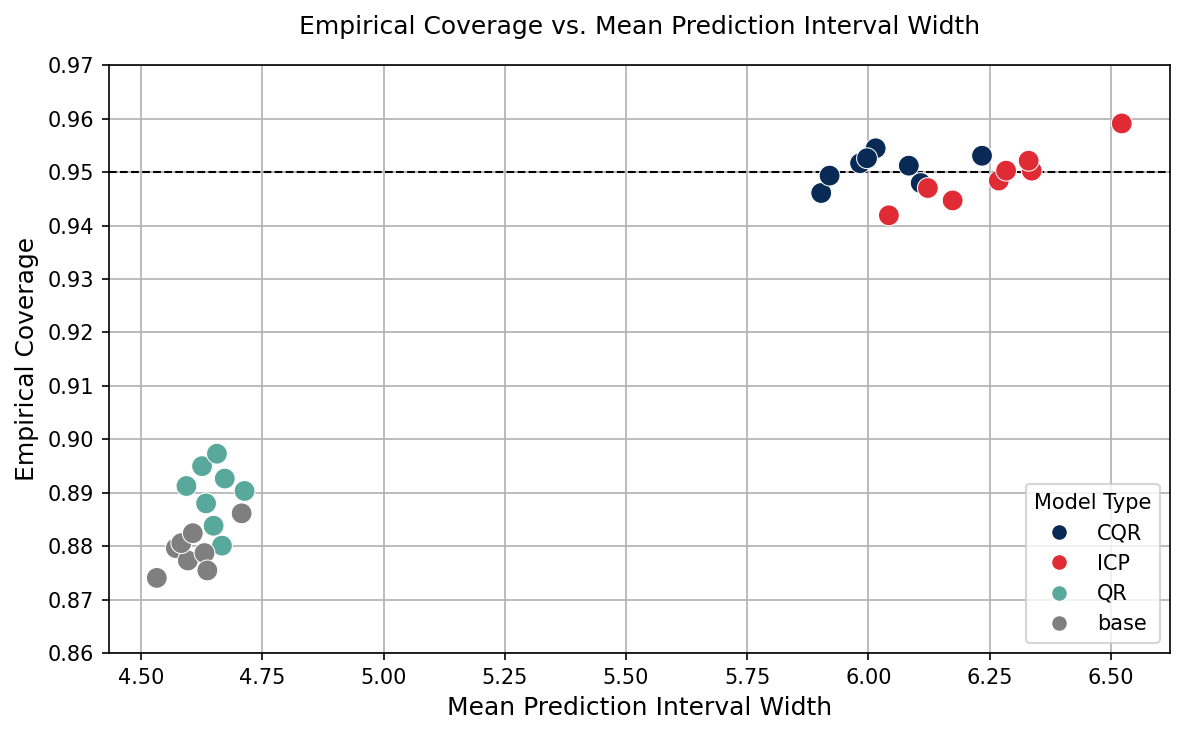

In [12]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}
df_AE_by_run_to_plot = df_AE_by_run.copy()
df_AE_by_run_to_plot['color'] = df_AE_by_run_to_plot['pred_model_type'].map(color_dict).fillna('black')

#
plot_coverage_vs_interval_width(
    mean_pred_interval_widths = df_AE_by_run_to_plot['mean_interval_width'],
    empirical_coverages = df_AE_by_run_to_plot['empirical_coverage'],
    model_types = df_AE_by_run_to_plot['pred_model_type'],
    colors = df_AE_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(8,5),
    dpi=150
)

## Histograma del ancho del intervalo con distinción de cobertura

In [13]:
# Añadir columna de ranking para 'mean_interval_score' dentro de cada grupo
df_AE_by_run = (
    df_AE_by_run
    .sort_values(['pred_model_type', 'confidence', 'mean_interval_width'])
    .assign(
        ranking_mean_interval_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_interval_score']
                                             .rank(method='dense')
    )
)

# Filtrar las mejores ejecuciones (ranking = 1)
best_runs = (
    df_AE_by_run[df_AE_by_run['ranking_mean_interval_score'] == 1]
    [['pred_model_type', 'confidence', 'iteration']]
)

# Unir con los datos originales para obtener solo la instancias de las mejores ejecuciones
df_best_AE_raw = pd.merge(
    df_AE_raw,
    best_runs,
    on=['pred_model_type', 'confidence', 'iteration'],
    how='inner'  # Solo conserva las coincidencias
)

display(df_best_AE_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


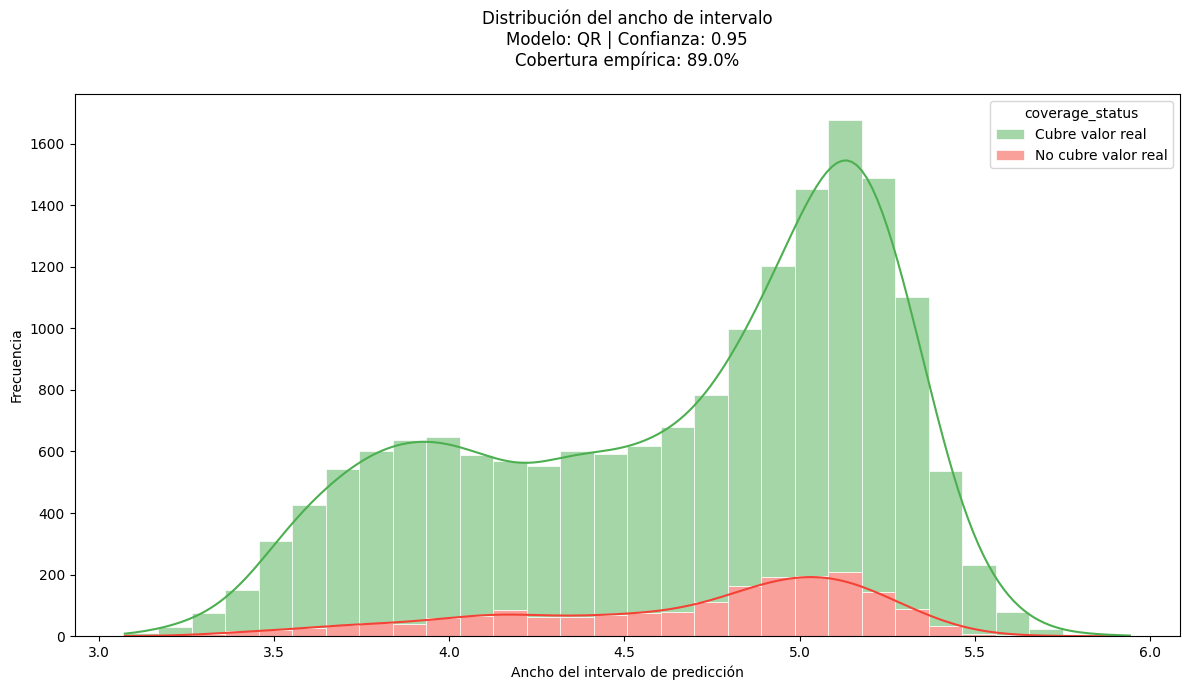

In [14]:
# Ejemplo de cómo usar la función
fig = plot_interval_width_histogram(df_AE_raw, pred_model_type='QR', confidence=0.95)
plt.show()

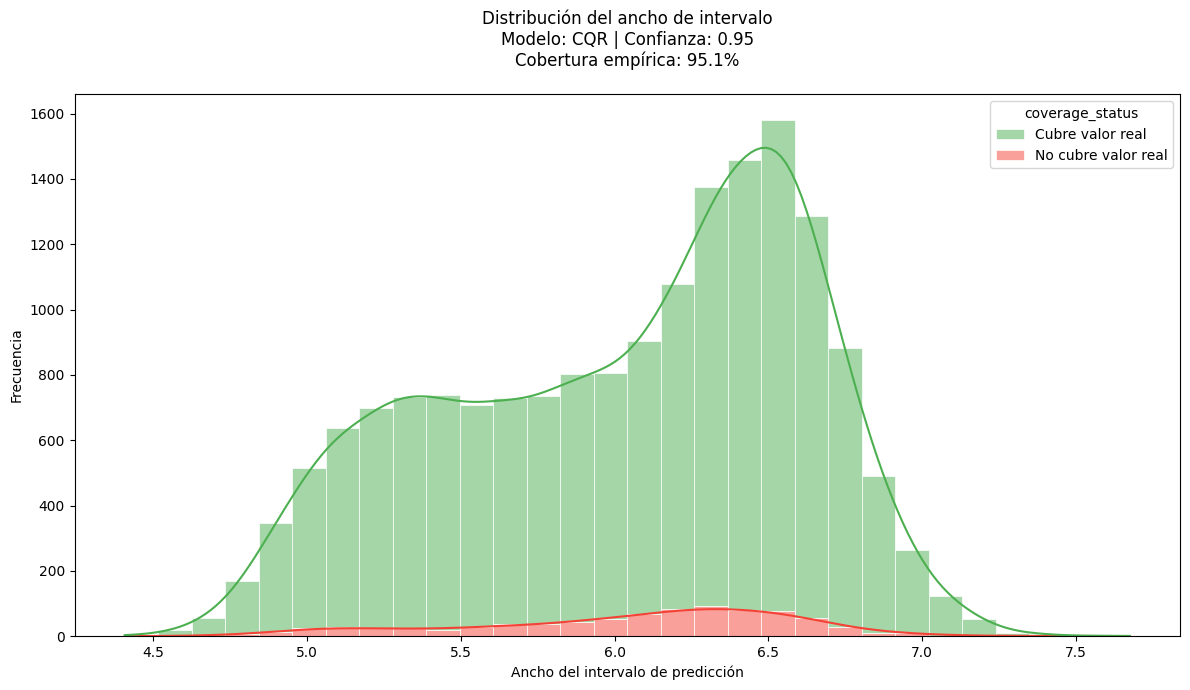

In [15]:
# Ejemplo de cómo usar la función
fig = plot_interval_width_histogram(df_AE_raw, pred_model_type='CQR', confidence=0.95)
plt.show()

## Análisis de la cobertura por tamaño del intervalo

In [16]:
df_AE_coverage_by_decile = df_AE_raw.copy()

df_AE_coverage_by_decile['interval_width_decile'] = df_AE_coverage_by_decile.groupby(
    ['pred_model_type', 'confidence']
)['pred_interval_width'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

df_AE_coverage_by_decile = df_AE_coverage_by_decile.groupby(
    ['pred_model_type', 'confidence', 'interval_width_decile']
).agg(
    mean_coverage=('is_covered', 'mean'),  # % de cobertura empírica
    mean_interval_width=('pred_interval_width', 'mean'),  # Ancho promedio del intervalo en el decil
    mean_interval_score=('interval_score', 'mean'),
    count=('is_covered', 'count')  # Número de muestras en el decil
).reset_index()

df_AE_coverage_by_decile['mean_coverage'] = (df_AE_coverage_by_decile['mean_coverage'] * 100).round(2)
df_AE_coverage_by_decile['mean_interval_width'] = df_AE_coverage_by_decile['mean_interval_width'].round(2)
df_AE_coverage_by_decile['mean_interval_score'] = df_AE_coverage_by_decile['mean_interval_score'].round(2)

display(df_AE_coverage_by_decile)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Análisis de la cobertura por edad en entero

In [17]:
# Clasifica en deciles dentro de cada grupo {pred_model_type, confidence}
df_best_AE_raw['interval_width_decile'] = df_best_AE_raw.groupby(
    ['pred_model_type', 'confidence']
)['pred_interval_width'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')  # q=10 para deciles
)

# Calcula la cobertura empírica por decil
coverage_by_decile = df_best_AE_raw.groupby(
    ['pred_model_type', 'confidence', 'interval_width_decile']
).agg(
    mean_coverage=('is_covered', 'mean'),  # % de cobertura empírica
    mean_interval_width=('pred_interval_width', 'mean'),  # Ancho promedio del intervalo en el decil
    mean_interval_score=('interval_score', 'mean'),
    count=('is_covered', 'count')  # Número de muestras en el decil
).reset_index()

# Opcional: Ordenar para mejor visualización
coverage_by_decile = coverage_by_decile.sort_values(
    ['pred_model_type', 'confidence', 'interval_width_decile']
)

coverage_by_decile_to_show = coverage_by_decile.copy()
coverage_by_decile_to_show['mean_coverage'] = (coverage_by_decile_to_show['mean_coverage'] * 100).round(2)
coverage_by_decile_to_show['mean_interval_width'] = coverage_by_decile_to_show['mean_interval_width'].round(2)
coverage_by_decile_to_show['mean_interval_score'] = coverage_by_decile_to_show['mean_interval_score'].round(2)

display(coverage_by_decile_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


# PROBLEMA 2 
# ESTIMACIÓN DE MAYORÍA DE EDAD

## Carga de resultados

In [18]:
# Carga de datos
df_AMM_raw = pd.read_csv('results/AMM_maxillofacial_test_results.csv')

display(df_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [19]:
# Nueva columna: verdaderos positivos
df_AMM_raw['TP'] = (df_AMM_raw['pred_class'] == 1) & (df_AMM_raw['true_class'] == 1)

# Nueva columna: verdaderos negativos
df_AMM_raw['TN'] = (df_AMM_raw['pred_class'] == 0) & (df_AMM_raw['true_class'] == 0)

# falsos positivos
df_AMM_raw['FP'] = (df_AMM_raw['pred_class'] == 1) & (df_AMM_raw['true_class'] == 0)

# Nueva columna: falsos negativos
df_AMM_raw['FN'] = (df_AMM_raw['pred_class'] == 0) & (df_AMM_raw['true_class'] == 1)

# Nueva columna: cobertura (true/false)
df_AMM_raw['is_covered'] = ((df_AMM_raw['true_class'] == 0) & (df_AMM_raw['pred_set_under_18'] == 1)) | \
                          ((df_AMM_raw['true_class'] == 1) & (df_AMM_raw['pred_set_over_18'] == 1))
                          
# Nueva columna: tamaño del conjunto de predicción
df_AMM_raw['pred_set_size'] = df_AMM_raw['pred_set_under_18'] + df_AMM_raw['pred_set_over_18']

# Nueva columna: set score
alpha = 1 - df_AMM_raw['confidence']
df_AMM_raw['set_score'] = df_AMM_raw['pred_set_size'] + 1/alpha * (~df_AMM_raw['is_covered'])

display(df_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [20]:
# Agrupar y calcular métricas
df_AMM_by_run = (
    df_AMM_raw
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': (g['TP'].sum() + g['TN'].sum()) / len(g),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AMM_by_run)

/tmp/ipykernel_26659/2631375322.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Tabla resumen por ejecución y media

In [21]:
# Redondear valores y formatear porcentaje
df_AMM_by_run_to_show = df_AMM_by_run.copy()
df_AMM_by_run_to_show['accuracy'] = df_AMM_by_run_to_show['accuracy'].round(2)
df_AMM_by_run_to_show['empirical_coverage'] = (df_AMM_by_run_to_show['empirical_coverage'] * 100).round(2)
df_AMM_by_run_to_show['mean_set_size'] = df_AMM_by_run_to_show['mean_set_size'].round(2)
df_AMM_by_run_to_show['mean_set_score'] = df_AMM_by_run_to_show['mean_set_score'].round(2)

# Ordenar por iteración y por tipo de predicción
df_AMM_by_run_to_show = sort_by_column(df_AMM_by_run_to_show, 'iteration')
custom_order = ['base', 'LAC', 'MCM']
df_AMM_by_run_to_show = sort_by_column(df_AMM_by_run_to_show, 'pred_model_type', custom_order)

display(df_AMM_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [22]:
# Agrupar por tipo de modelo y confianza
df_AMM_by_pred_model_type_to_show = (
    df_AMM_by_run
    .groupby(['pred_model_type', 'confidence'])
    .apply(lambda group: pd.Series({
        'mean_accuracy': round(group['accuracy'].mean(), 2),
        'mean_empirical_coverage': round(group['empirical_coverage'].mean() * 100, 2), 
        'mean_mean_set_size': round(group['mean_set_size'].mean(), 2),
        'mean_mean_set_score': round(group['mean_set_score'].mean(), 2)
    }))
    .reset_index()
)

# Ordenar por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_AMM_by_pred_model_to_show = sort_by_column(df_AMM_by_pred_model_type_to_show, 'pred_model_type', custom_order)

display(df_AMM_by_pred_model_type_to_show)

/tmp/ipykernel_26659/1447828454.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Gráfica de dispersión Empirical Coverage - Mean Set Size

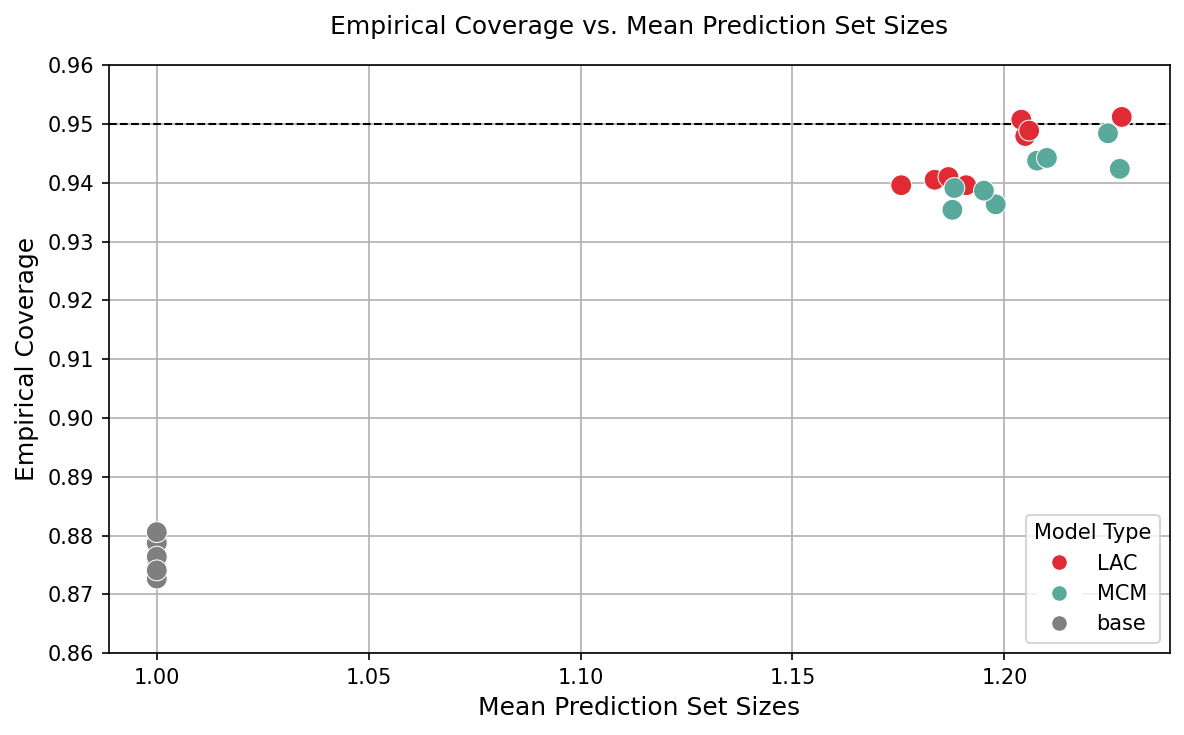

In [23]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c'}
df_AMM_by_run_to_plot = df_AMM_by_run.copy()
df_AMM_by_run_to_plot['color'] = df_AMM_by_run_to_plot['pred_model_type'].map(color_dict).fillna('black')

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AMM_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AMM_by_run_to_plot['empirical_coverage'],
    model_types=df_AMM_by_run_to_plot['pred_model_type'],
    colors=df_AMM_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## Análisis de la cobertura por clase

Análisis sobre cada ejecución de cada tipo de predicción

## Matriz de confusión conformal y análisis de la cobertura por clase

In [24]:
# Añadir columna de ranking para 'mean_set_score' dentro de cada grupo
df_AMM_by_run = (
    df_AMM_by_run
    .sort_values(['pred_model_type', 'confidence', 'mean_set_size'])
    .assign(
        ranking_mean_set_score=lambda x: x.groupby(['pred_model_type', 'confidence'])['mean_set_score']
                                             .rank(method='dense')
    )
)

# Filtrar las mejores ejecuciones (ranking = 1)
best_runs = (
    df_AMM_by_run[df_AMM_by_run['ranking_mean_set_score'] == 1]
    [['pred_model_type', 'confidence', 'iteration']]
)

# Unir con los datos originales para obtener solo la instancias de las mejores ejecuciones
df_best_AMM_raw = pd.merge(
    df_AMM_raw,
    best_runs,
    on=['pred_model_type', 'confidence', 'iteration'],
    how='inner'  # Solo conserva las coincidencias
)

display(df_best_AMM_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


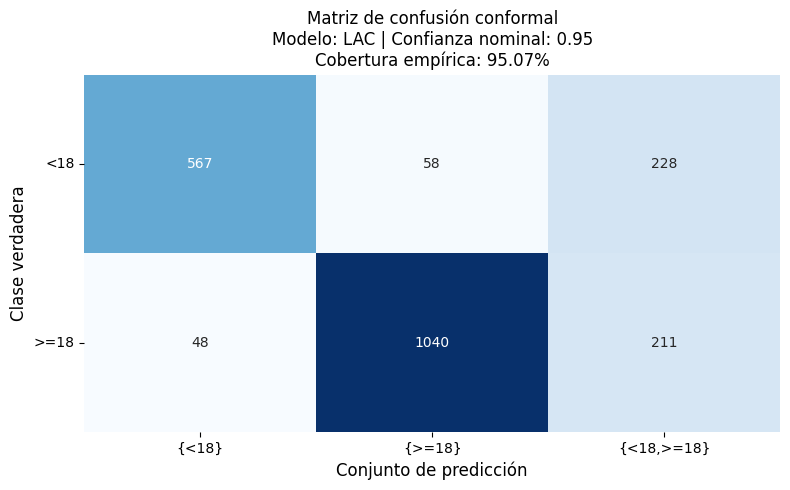

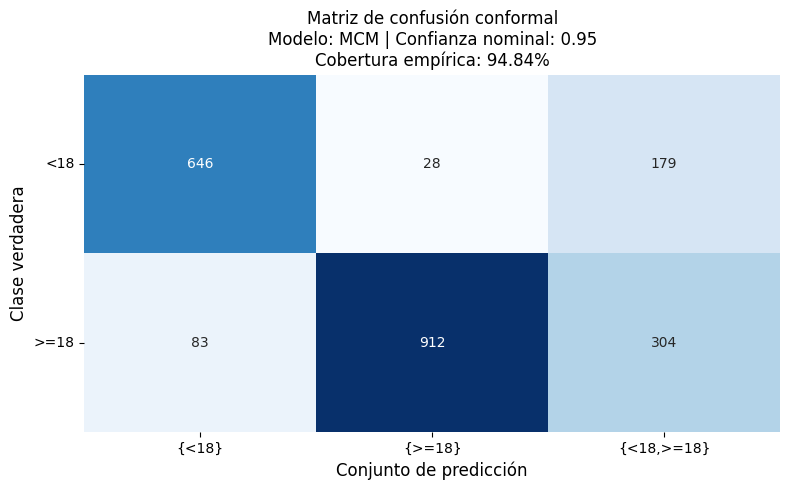

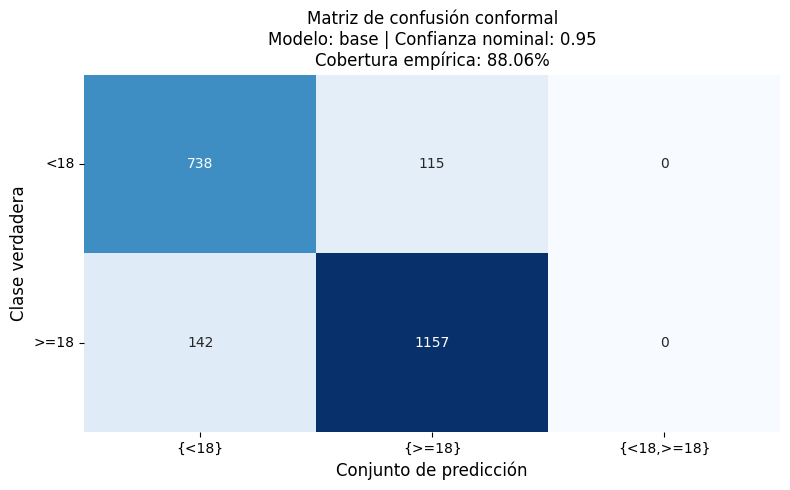

In [25]:
def pred_set_label(row):
    if row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 0:
        return '{<18}'
    elif row['pred_set_under_18'] == 0 and row['pred_set_over_18'] == 1:
        return '{>=18}'
    elif row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 1:
        return '{<18,>=18}'
    else:
        return '∅'  # Por si acaso, aunque dices que nunca ocurre

df_best_AMM_raw['pred_set_label'] = df_best_AMM_raw.apply(pred_set_label, axis=1)

confusion_conformal = (
    df_best_AMM_raw
    .groupby(['pred_model_type', 'confidence', 'true_class', 'pred_set_label'])
    .size()
    .reset_index(name='count')
)

empirical_coverage_by_group = (
    df_best_AMM_raw
    .groupby(['pred_model_type', 'confidence'])['is_covered']
    .mean()
    .reset_index(name='empirical_coverage')
)

coverage_dict = {
    (row['pred_model_type'], row['confidence']): row['empirical_coverage']
    for _, row in empirical_coverage_by_group.iterrows()
}

# Posibles etiquetas de columnas en orden
pred_set_labels = ['{<18}', '{>=18}', '{<18,>=18}']

# Dibujar una matriz por cada combinación
for (model, conf), group in confusion_conformal.groupby(['pred_model_type', 'confidence']):
    # Crear tabla cruzada (confusion matrix)
    pivot = group.pivot(index='true_class', columns='pred_set_label', values='count').fillna(0)

    # Asegurar columnas en orden
    for label in pred_set_labels:
        if label not in pivot.columns:
            pivot[label] = 0
    pivot = pivot[pred_set_labels]
    
    coverage = coverage_dict.get((model, conf), None)
    coverage_str = f'{coverage:.2%}' if coverage is not None else 'N/A'

    # Plot
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='Blues', cbar=False)
    plt.title(f'Matriz de confusión conformal\nModelo: {model} | Confianza nominal: {conf}\nCobertura empírica: {coverage_str}')
    plt.xlabel('Conjunto de predicción', fontsize=12)
    plt.ylabel('Clase verdadera', fontsize=12)
    plt.yticks([0.5, 1.5], ['<18', '>=18'], rotation=0)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# PROBLEMA 3
# ESTIMACIÓN DE CLASIFICACIÓN EN SEXO Y MAYORÍA DE EDAD

## Carga de datos

In [26]:
# Carga de datos
df_AMSC_raw = pd.read_csv('results/AMSC_maxillofacial_test_results.csv')

display(df_AMSC_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [27]:
# Nueva columna: cobertura (true/false)
df_AMSC_raw['well_classified'] = (df_AMSC_raw['true_class'] == df_AMSC_raw['pred_class'])

# Nueva columna: cobertura (true/false)
df_AMSC_raw['is_covered'] = (
    ((df_AMSC_raw['true_class'] == 0) & (df_AMSC_raw['pred_set_male_under_18'] == 1)) |
    ((df_AMSC_raw['true_class'] == 1) & (df_AMSC_raw['pred_set_male_over_18'] == 1)) |
    ((df_AMSC_raw['true_class'] == 2) & (df_AMSC_raw['pred_set_female_under_18'] == 1)) |
    ((df_AMSC_raw['true_class'] == 3) & (df_AMSC_raw['pred_set_female_over_18'] == 1))
)

# Nueva columna: tamaño del conjunto de predicción
df_AMSC_raw['pred_set_size'] = (
    df_AMSC_raw['pred_set_male_under_18'] + df_AMSC_raw['pred_set_male_over_18'] + 
    df_AMSC_raw['pred_set_female_under_18'] + df_AMSC_raw['pred_set_female_over_18']
)

# Nueva columna: set score
alpha = 1 - df_AMSC_raw['confidence']
df_AMSC_raw['set_score'] = df_AMSC_raw['pred_set_size'] + 1/alpha * (~df_AMSC_raw['is_covered'])

display(df_AMSC_raw)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [28]:
# Agrupar y calcular métricas
df_AMSC_by_run = (
    df_AMSC_raw
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': g['well_classified'].mean(),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AMSC_by_run)

/tmp/ipykernel_26659/16689953.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Tabla resumen por ejecución y media

In [29]:
# Redondear valores y formatear porcentaje
df_AMSC_by_run_to_show = df_AMSC_by_run.copy()
df_AMSC_by_run_to_show['accuracy'] = df_AMSC_by_run_to_show['accuracy'].round(2)
df_AMSC_by_run_to_show['empirical_coverage'] = (df_AMSC_by_run_to_show['empirical_coverage'] * 100).round(2)
df_AMSC_by_run_to_show['mean_set_size'] = df_AMSC_by_run_to_show['mean_set_size'].round(2)
df_AMSC_by_run_to_show['mean_set_score'] = df_AMSC_by_run_to_show['mean_set_score'].round(2)

# Ordenar por iteración y por tipo de predicción
df_AMSC_by_run_to_show = sort_by_column(df_AMSC_by_run_to_show, 'iteration')
custom_order = ['base', 'LAC', 'MCM']
df_AMSC_by_run_to_show = sort_by_column(df_AMSC_by_run_to_show, 'pred_model_type', custom_order)

display(df_AMSC_by_run_to_show)

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Gráfica de dispersión Empirical Coverage - Mean Set Size

## Análisis de la cobertura por clase

## Diagrama de Venn para conjuntos de predicciones

Este nos permite ver qué clases suelen estar juntas en un conjunto de predicciones

# PROBLEMA 4
# ESTIMACIÓN DE EDAD COMO PROBLEMA DE CLASIFICACIÓN